<a href="https://colab.research.google.com/github/zenaiev/hep/blob/main/invmass/invmass_adv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install ROOT

In [1]:
!wget https://root.cern/download/root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz
!tar -xzf root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz
import os
pwd = os.getcwd()
os.environ['ROOTSYS'] = pwd + '/root'
os.environ['PATH'] += ':' + pwd + '/root/bin'
os.environ['LD_LIBRARY_PATH'] += ':' + pwd + '/root/lib'
import sys
sys.path.append(pwd + '/root/lib')
import ROOT
print(ROOT.__version__)

--2024-09-26 01:11:39--  https://root.cern/download/root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz
Resolving root.cern (root.cern)... 188.184.49.144, 2001:1458:d00:55::100:c
Connecting to root.cern (root.cern)|188.184.49.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300006880 (286M) [application/x-gzip]
Saving to: ‘root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz.2’

root_v6.32.04.Linux 100%[===================>] 286.11M  27.4MB/s    in 11s     

2024-09-26 01:11:51 (25.2 MB/s) - ‘root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz.2’ saved [300006880/300006880]

6.32.04


Generate particles, write them to TTree, fill and fit TH1, draw. Apply cuts, calculate efficiency.

Notice the usage of sys.argv to simulate passing command line arguments.

100%|██████████| 1000/1000 [00:13<00:00, 73.23it/s]


Number of signal events #1 = 92.07468154086754 +- 15.25410634676726
Number of signal events #2 = 871.0703763440207 +- 52.40948678305771
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      298.438
NDf                       =          260
Edm                       =  1.36363e-07
NCalls                    =         1837
p0                        =     0.920747   +/-   0.152541    
p1                        =     0.499796   +/-   0.00218901   	 (limited)
p2                        =    0.0112899   +/-   0.00225813   	 (limited)
p3                        =       8.7107   +/-   0.524095    
p4                        =      1.86343   +/-   0.00393111   	 (limited)
p5                        =    0.0633044   +/-   0.00369322   	 (limited)
p6                        =       8.5002   +/-   0.0487017   
p7                        =     -14.2857   +/-   0.0635651   
p8                        =      16.4562   +/-   0.0328377   
p9                     

Warning in <TROOT::Append>: Replacing existing TH1: hInvMass (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file invmass_adv.pdf has been created
Info in <TCanvas::Print>: png file invmass_adv.png has been created


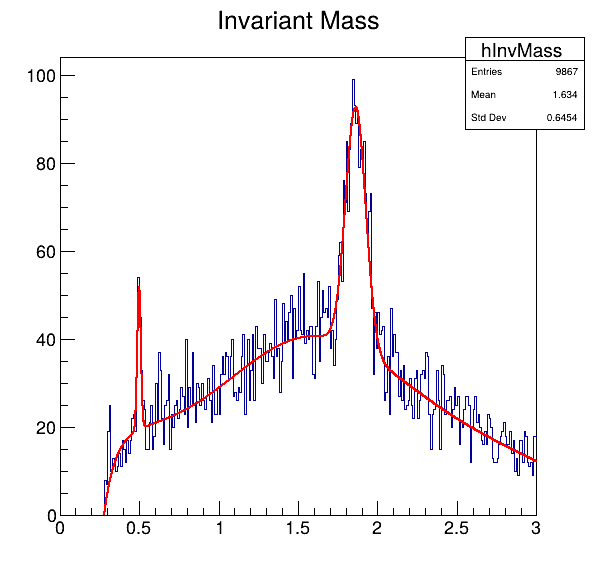

In [21]:
import ROOT
import math
import random
import tqdm
import sys
import argparse
from matplotlib import pyplot as plt

def generate_and_decay(particle):
  # Input parameters
  parent_mass = particle[0]
  daughter_masses = particle[1]
  # currently we support only stable particles or two-body decays
  assert len(daughter_masses) in [0, 2]
  # lambda parameter of exponential distribution (can be different for different particles)
  if len(particle) > 2:
    exp_lambda = particle[2]
  else:
    exp_lambda = 1.0

  # Generate random values for momentum and direction
  momentum = random.expovariate(exp_lambda)  # Exponential distribution for momentum
  theta = random.uniform(0, math.pi)       # Uniform in [0, pi]
  phi = random.uniform(0, 2 * math.pi)     # Uniform in [0, 2pi]

  # Create a 3-momentum vector using spherical coordinates
  px = momentum * math.sin(theta) * math.cos(phi)
  py = momentum * math.sin(theta) * math.sin(phi)
  pz = momentum * math.cos(theta)

  # Create parent particle
  parent = ROOT.Math.PxPyPzMVector(px, py, pz, parent_mass)

  if len(daughter_masses) == 0:
    tracks = [parent]
  elif len(daughter_masses) == 2:
    daughter_mass_1, daughter_mass_2 = daughter_masses
    # Decay
    daughter1, daughter2 = two_body_decay(parent, daughter_mass_1, daughter_mass_2)
    tracks = [daughter1, daughter2]

    if 0:
      print(f'parent: {parent}, m = {parent.M()}')
      print(f'daughter1: {daughter1}, m = {daughter1.M()}')
      print(f'daughter2: {daughter2}, m = {daughter2.M()}')
      #sys.exit(0)

  # Smear momentum of daughter tracks
  tracks_smeared = []
  for itrack,track in enumerate(tracks):
    tracks_smeared.append(smear_momentum(track))
    if 0:
      print(f'itrack {itrack}: {track}, m = {track.M()}')
      sys.exit(0)

  return tracks_smeared

# Function to smear particle momentum
def smear_momentum(particle):
  fluct = random.normalvariate(1., 0.05) # Normal distribution with mean = 1 and width = 0.05 (5% resolution)
  return ROOT.Math.PxPyPzMVector(particle.X() * fluct, particle.Y() * fluct, particle.Z() * fluct, particle.M())

# Function to generate a two-body decay in the rest frame of the parent particle
def two_body_decay(parent, m1, m2):
  # Calculate the momentum of the daughter particles in the parent's rest frame
  m0 = parent.M()  # Parent mass

  # Energy of the daughters in the rest frame
  # In the rest frame, the daughters have equal momenta (p12)
  #p12 = math.sqrt((m0**2 - (m1 + m2)**2) * (m0**2 - (m1 - m2)**2)) / (2 * m0)
  E1 = (m0**2 + m1**2 - m2**2) / (2 * m0)
  #E2 = (m0**2 + m2**2 - m1**2) / (2 * m0)

  # Momentum of the daughters in the rest frame
  p = math.sqrt(E1**2 - m1**2)
  #print(p, p12)

  # Generate random angles for isotropic decay
  theta = random.uniform(0, math.pi)
  phi = random.uniform(0, 2 * math.pi)

  # Momentum components for daughter 1 in the rest frame
  p1x = p * math.sin(theta) * math.cos(phi)
  p1y = p * math.sin(theta) * math.sin(phi)
  p1z = p * math.cos(theta)

  # Create four-momentum vectors for the two daughters in the rest frame
  daughter1 = ROOT.Math.PxPyPzMVector(p1x, p1y, p1z, m1)
  daughter2 = ROOT.Math.PxPyPzMVector(-p1x, -p1y, -p1z, m2)

  # Boost daughters back to the lab frame if the parent is moving
  boost_vector = ROOT.Math.Boost(parent.BoostToCM())
  daughter1 = ROOT.Math.PxPyPzMVector(boost_vector(daughter1))
  daughter2 = ROOT.Math.PxPyPzMVector(boost_vector(daughter2))

  return daughter1, daughter2

# particles is a list of [m_parent, m_daughters]
# m_daughters is a list of daughets (if empty, no decay)
def generate_events(nevents, particles=[], hInvMass=None, tree=None, tracks_vec_for_ttree=None, pmin=None):
  tracks_all = []
  # Loop over particles and generate random kinematics
  #for i in range(nParticles):
  for i in tqdm.tqdm(range(nevents)):
    tracks = []
    for particle in particles:
      tracks += generate_and_decay(particle)
    tracks_all += tracks

    if tree is not None and tracks_vec_for_ttree is not None:
      tracks_vec.clear()
      for tr in tracks:
        tracks_vec.push_back(tr)
      tree.Fill()

    if hInvMass is not None:
      # Fill the invariant mass histogram
      for itr1 in range(len(tracks)):
        for itr2 in range(itr1 + 1, len(tracks)):
          if pmin is None or all(tr.P() >= pmin for tr in [tracks[itr1], tracks[itr2]]):
            hInvMass.Fill((tracks[itr1] + tracks[itr2]).M())

  # Return all tracks
  return tracks_all

def study_momenta():
  nevents = 1000
  # Create and fill histograms for partcile momentum
  hmom_dzero = ROOT.TH1F("hmom_dzero", "Momentum of D0", 30, 0, 3)
  for tr in generate_events(nevents, [[mass_d_zero, [mass_pi_ch]*2]]):
    hmom_dzero.Fill(tr.P())
  hmom_kzero = ROOT.TH1F("hmom_kzero", "Momentum of K0", 30, 0, 3)
  for tr in generate_events(nevents, [[mass_k_zero, [mass_pi_ch]*2]]):
    hmom_kzero.Fill(tr.P())
  hmom_pich = ROOT.TH1F("hmom_pich", "Momentum of standalone pi+/pi-", 30, 0, 3)
  for tr in generate_events(nevents, [[mass_pi_ch, []] for i in range(10)]):
    hmom_pich.Fill(tr.P())
  # Re-normalize histograms to the same area (1)
  for h in [hmom_dzero, hmom_kzero, hmom_pich]:
    h.Scale(1./h.GetEntries())
  # Draw results
  hmom_dzero.SetLineColor(ROOT.kRed)
  hmom_kzero.SetLineColor(ROOT.kBlue)
  hmom_pich.SetLineColor(ROOT.kBlack)
  hmom_dzero.GetXaxis().SetTitle('p [GeV]')
  hmom_dzero.GetYaxis().SetTitle('Arbitrary units')
  hmom_dzero.GetYaxis().SetTitleOffset(1.5)
  canvas = ROOT.TCanvas("canvas", "Particle momenta", 600, 600)
  hmom_dzero.SetMaximum(1.1 * max(h.GetMaximum() for h in [hmom_dzero, hmom_kzero, hmom_pich]))
  hmom_dzero.Draw('hist')
  hmom_kzero.Draw('hist same')
  hmom_pich.Draw('hist same')
  legend = ROOT.TLegend(0.5,0.75,0.75,0.9)
  legend.AddEntry(hmom_dzero, "D0", "l")
  legend.AddEntry(hmom_kzero, "K0", "l")
  legend.AddEntry(hmom_pich, "pi+,pi-", "l")
  legend.Draw()
  canvas.SaveAs("momenta.pdf")
  canvas.SaveAs("momenta.png")
  # Draw results using matplotlib (plt)
  fig,ax = plt.subplots()
  x = [hmom_dzero.GetBinLowEdge(b+1) for b in range(hmom_dzero.GetNbinsX()+1)]
  toplots = [[hmom_dzero, 'D0'], [hmom_kzero, 'K0'], [hmom_pich, 'pi+,pi-']]
  for toplot in toplots:
    h,label = toplot
    y = [h.GetBinContent(b+1) for b in range(h.GetNbinsX())]
    y = y + [y[-1]]
    ax.step(x, y, where='post', label=label)
  ax.set_xlim(hmom_dzero.GetBinLowEdge(1), hmom_dzero.GetBinLowEdge(hmom_dzero.GetNbinsX()+1))
  ax.set_ylim(bottom=0)
  ax.set_xlabel('p [GeV]')
  ax.set_ylabel('Arbitrary units')
  ax.legend()
  #plt.show()
  fig.savefig('momenta_plt.pdf')
  fig.savefig('momenta_plt.png')

if __name__ == '__main__':
  # Simulate command line arguments
  sys.argv = ['']
  #sys.argv = ['', '-t']
  #sys.argv = ['', '-r']
  #sys.argv = ['', '-m']
  #sys.argv = ['', '-e']

  parser = argparse.ArgumentParser()
  parser.add_argument('-t', '--tree', action='store_true', help='store TTree')
  parser.add_argument('-r', '--readtree', action='store_true', help='read TTree')
  parser.add_argument('-m', '--momenta', action='store_true', help='study momenta')
  parser.add_argument('-e', '--efficiency', action='store_true', help='calculate efficiency for D0')
  args = parser.parse_args()

  # Particle masses in GeV [https://pdg.lbl.gov/]
  mass_pi_ch = 0.13957
  mass_k_zero = 0.497611
  mass_d_zero = 1.86484
  mass_b_zero = 5.27972

  # Cut on particle momentum in GeV
  #pmin = None
  pmin = 0.7

  # random seed for reproducible results
  random.seed(42)

  # Create a histogram to store generated momenta
  hInvMass = ROOT.TH1F("hInvMass", "Invariant Mass", 300, 0, 3)
  #hInvMass = ROOT.TH1F("hInvMass", "Invariant Mass", 600, 0, 6)

  # Study distribution of particle momenta
  if args.momenta:
    study_momenta()
    sys.exit(0)

  # Calculate efficiency for D0
  if args.efficiency:
    nevents = 10000
    generate_events(10000, [[mass_d_zero, [mass_pi_ch]*2]], hInvMass, None, None, pmin)
    nevents_sel = hInvMass.GetEntries()
    efficiency = nevents_sel / nevents
    print(f'efficiency(D0, pmin = {pmin}) = {efficiency:.3f}')
    #sys.exit(0)

  if not args.readtree:
    # Set the number of events to generate
    nevents = 1000

    # Particles to generate in each event
    particles = [
      [mass_k_zero, [mass_pi_ch]*2], # K0 -> pi+ pi-
      [mass_d_zero, [mass_pi_ch]*2], # D0 -> pi+ pi-
#      [mass_b_zero, [mass_pi_ch]*2], # B0 -> pi+ pi-
    ]
    particles += [[mass_pi_ch, []] for i in range(5)] # 5 pi+/pi-

    if args.tree:
      # Create tree (store events)
      fileout = ROOT.TFile("tracks_adv.root", "recreate")
      tree = ROOT.TTree('tree', 'Tree with tracks')
      tracks_vec = ROOT.std.vector(ROOT.Math.PxPyPzMVector)()
      branch = tree.Branch('tracks', tracks_vec)
    else:
      tree = None
      tracks_vec = None

    # Generate events
    tracks = generate_events(nevents, particles, hInvMass, tree, tracks_vec, pmin)

    # Write TTree to file
    if args.tree:
      fileout.cd()
      tree.Write()
      fileout.Close()

  else:
    # Read data from TTree
    filein = ROOT.TFile("tracks_adv.root")
    tree = filein.Get('tree')
    tracks = ROOT.std.vector(ROOT.Math.PxPyPzMVector)()
    tree.SetBranchAddress('tracks', tracks)
    for ientr in range(tree.GetEntries()):
      tree.GetEntry(ientr)
      for itr1 in range(len(tracks)):
        for itr2 in range(itr1 + 1, len(tracks)):
          if pmin is None or all(tr.P() >= pmin for tr in [tracks[itr1], tracks[itr2]]):
            hInvMass.Fill((tracks[itr1] + tracks[itr2]).M())

  # Fit
  fitFunc = ROOT.TF1("fitFunc",
                     "[0]/(sqrt(2*TMath::Pi())*[2])*TMath::Exp(-0.5*((x-[1])/[2])^2)"   # First Gaussian
                     " + [3]/(sqrt(2*TMath::Pi())*[5])*TMath::Exp(-0.5*((x-[4])/[5])^2)" # Second Gaussian
                     #" + [6] + [7]*x + [8]*x^2 + [9]*x^3 + [10]*x^4 + [11]*x^5",               # Polynomial (5th degree)
                     " + (x - 0.13957*2) * exp(pol5(6))", # Exponent of polynomial (5th degree) x (step function)
            0.13957*2, 10)
  fitFunc.SetParameters(1, 0.5, 0.01,  # Amplitude, mean, sigma of first Gaussian
                        1, 1.85, 0.05,  # Amplitude, mean, sigma of second Gaussian
                        0, 0, 0, 0, 0);    # Coefficients of the polynomial (0 by default anyway)
  #fitFunc.FixParameter(0, 0.)
  fitFunc.SetNpx(10000)
  fitFunc.SetParLimits(1, 0.48, 0.52) # K0 mass
  fitFunc.SetParLimits(2, 0., 0.02) # K0 width
  fitFunc.SetParLimits(4, 1.8, 1.9) # D0 mass
  fitFunc.SetParLimits(5, 0.01, 0.1) # D0 width
  hInvMass.Fit(fitFunc)
  bin_width = hInvMass.GetBinLowEdge(2) - hInvMass.GetBinLowEdge(1)
  print(f'Number of signal events #1 = {fitFunc.GetParameter(0)/bin_width} +- {fitFunc.GetParError(0)/bin_width}')
  print(f'Number of signal events #2 = {fitFunc.GetParameter(3)/bin_width} +- {fitFunc.GetParError(3)/bin_width}')

  # Create a canvas to draw the histogram
  canvas = ROOT.TCanvas("canvas", "Invariant Mass", 600, 600)
  hInvMass.Draw()

  # Save the histogram as an image
  canvas.SaveAs("invmass_adv.pdf")
  canvas.SaveAs("invmass_adv.png")

  # test if we get the expected result
  #print(fitFunc.GetParameter(0))
  #assert fitFunc.GetParameter(0) == 9.940388645786218 # this might be machine dependent: consider to lower precision
